In [ ]:
from sklearn.tree import DecisionTreeClassifier

from helpers import *
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
import warnings


warnings.filterwarnings("ignore")

# read raw csv file
pokemon = read_csv("pokemon.csv")

combats = read_csv("combats.csv")

combat_tests = read_csv("tests.csv")

# clean some stuff
pokemon = cleanDataSet(pokemon)

pokemon_combats_df = pokemon.copy()

# insert image path as a new column
# some images have incorrect name... but oh well couldnt find a better image set
pokemon.insert(12, "images", "images/" + pokemon['Name'] + ".png")

# Find pokemon that didnt win a single combat !
total_wins = combats.Winner.value_counts()
numberOfWins = combats.groupby('Winner').count()
countByFirst = combats.groupby('Second_pokemon').count()
countBySecond = combats.groupby('First_pokemon').count()

losing_pokemon = np.setdiff1d(countByFirst.index.values, numberOfWins.index.values) - 1
losing_pokemon = pokemon.iloc[losing_pokemon[0],]
#showPokemonImage(pokemon, losing_pokemon.values[0])


# List pokemons that won the most
numberOfWins = numberOfWins.sort_index()
numberOfWins['Total Fights'] = countByFirst.Winner + countBySecond.Winner
numberOfWins['Win Percentage'] = numberOfWins.First_pokemon / numberOfWins['Total Fights']

final_result = pd.merge(pokemon, numberOfWins, left_on="Pokedex Number", right_index=True, how='left')

print(final_result.describe().to_string())

final_result[np.isfinite(final_result['Win Percentage'])].sort_values(by = ['Win Percentage'], ascending=False).head(10)


# Show the types that win the most
print(final_result.groupby('Type 1').agg({"Win Percentage": "mean"}).sort_values(by = "Win Percentage", ascending=False))


# LETS DO SOME MACHINE LEARNING NOW

# Combat winner prediction
combats.Winner[combats.Winner == combats.First_pokemon] = 0
combats.Winner[combats.Winner == combats.Second_pokemon] = 1

type_dict, stats_dict = createDictionaries(pokemon_combats_df)


combats = replace(combats, stats_dict, type_dict)
train_df = get_difference_stats(combats)
train_df = normalize(train_df)

y_train_full = train_df['Winner']
x_train_full = train_df.drop('Winner', axis=1)

# Undersampled data

undersample = train_df.sample(200)

y_train_full_undersampled = undersample['Winner']
x_train_full_undersampled = undersample.drop('Winner', axis=1)

test_size = 0.2
x_train, x_cv, y_train, y_cv = train_test_split(x_train_full, y_train_full,
                                                test_size=test_size)

# Type prediction

types = list(pokemon['Type 1'].unique())
test_data = pd.DataFrame(columns=pokemon.columns)

frac = 0.1
for type in types:
    test_data = test_data.append((pokemon[pokemon['Type 1'] == type]).sample(frac=frac))

train_data = pokemon[~pokemon['Name'].isin(test_data['Name'])]

# scale features
max_abs_scaler = preprocessing.MaxAbsScaler()

# 4-10: from Total to Speed
x_train_type = max_abs_scaler.fit_transform(train_data.iloc[:, 4:10])
x_test_type = max_abs_scaler.fit_transform(test_data.iloc[:, 4:10])

array_train = train_data.values
array_test = test_data.values

y_train_type = array_train[:, 2]
y_test_type = array_test[:, 2]

algorithms = {'naive bayes': GaussianNB(),
            'log reg': LogisticRegression(),
            'Decision Tree': DecisionTreeClassifier(),
            'random forest': RandomForestClassifier(n_estimators=100)}


for name, algorithm in algorithms.items():
    start_time = time.time()
    model = algorithm.fit(x_train, y_train)
    pred = model.predict(x_cv)
    print('Combat prediction, Accuracy of {}:'.format(name), accuracy_score(pred, y_cv), " in", time.time() - start_time, "seconds")
    start_time = time.time()
    model_type = algorithm.fit(x_train_type, y_train_type)
    pred_type = model_type.predict(x_test_type)
    print('Type prediction, Accuracy of {}:'.format(name), accuracy_score(pred_type, y_test_type), " in", time.time() - start_time, "seconds")





# Random forest appeared to be the best one
tests = read_csv("tests.csv")
prediction_df = tests.copy()
test_df = replace(tests.copy(), stats_dict, type_dict)
test_df = get_difference_stats(test_df)
test_df = normalize(test_df)


classifier = RandomForestClassifier(n_estimators=100)
model = classifier.fit(x_train_full, y_train_full)
prediction = model.predict(test_df)


# Oversampling legendaries with smote

X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(x_train_full_undersampled,y_train_full_undersampled, test_size = 0.30)

sm = SMOTE(random_state=12, sampling_strategy=1.0)
X_train_res, y_train_res = sm.fit_sample(X_train_smote, y_train_smote)

model_with_smote = classifier.fit(X_train_res, y_train_res)
pred_with_smote = model_with_smote.predict(X_test_smote)

print("Accuracy with random forest using smote ",  accuracy_score(pred_with_smote, y_test_smote))

############### Visualizing a random tree ##############

# This generates a .dot file. Afterwards use a online .dot visualizer to convert to .svg or .png

#estimator = model.estimators_[5]

#export_graphviz(estimator,
                #out_file='tree.dot',
                #feature_names = x_train_full.columns,
                #rounded = True, proportion = False,
                #precision = 2, filled = True)



#for i in range(10):

    #if prediction[i] == 0:
       # winner = tests.loc[i]['First_pokemon']
    #else:
       # winner = tests.loc[i]['Second_pokemon']

    #print(tests.loc[i]['First_pokemon'], "(",getPokemonName(pokemon,tests.loc[i]['First_pokemon']), ") x ",
         # tests.loc[i]['Second_pokemon'], "(",getPokemonName(pokemon,tests.loc[i]['Second_pokemon']), ")"  ", Winner = ", winner)


########## SOME PRELIMINARY DATA VISUALIZATION ##########

#Most important features of the model

feat_importances = pd.Series(model.feature_importances_, index=x_train_full.columns)
feat_importances.nlargest(10).plot(kind='barh')


#visualizeLegendaries(pokemon)

#plt.show()


# 2. Proportion of each type
# visualizeTypeDistribution(pokemon)

# 3. View correlation of each stat
# inspectCorrelations(pokemon)

# plt.show()


In [4]:
1+1


2

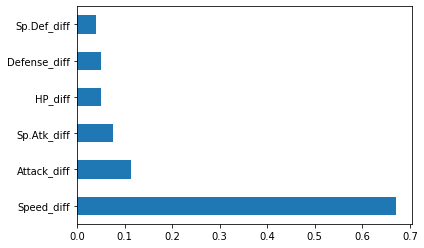

In [5]:
feat_importances = pd.Series(model.feature_importances_, index=x_train_full.columns)
feat_importances.nlargest(10).plot(kind='barh')

In [6]:
showHTMLDataFrame(pokemon)

,Pokedex Number,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,images
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False,
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False,
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False,
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False,
4,5,Charmander,Fire,None,39,52,43,60,50,65,1,False,
5,6,Charmeleon,Fire,None,58,64,58,80,65,80,1,False,
6,7,Charizard,Fire,Flying,78,84,78,109,85,100,1,False,
7,8,Mega Charizard X,Fire,Dragon,78,130,111,130,85,100,1,False,
8,9,Mega Charizard Y,Fire,Flying,78,104,78,159,115,100,1,False,
9,10,Squirtle,Water,None,44,48,65,50,64,43,1,False,


In [7]:
pokemon.describe()

,Pokedex Number,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation
count,800.0000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.00000
mean,400.5000,69.258750,79.001250,73.842500,72.820000,71.902500,68.277500,3.32375
std,231.0844,25.534669,32.457366,31.183501,32.722294,27.828916,29.060474,1.66129
min,1.0000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000,1.00000
25%,200.7500,50.000000,55.000000,50.000000,49.750000,50.000000,45.000000,2.00000
50%,400.5000,65.000000,75.000000,70.000000,65.000000,70.000000,65.000000,3.00000
75%,600.2500,80.000000,100.000000,90.000000,95.000000,90.000000,90.000000,5.00000
max,800.0000,255.000000,190.000000,230.000000,194.000000,230.000000,180.000000,6.00000


In [10]:
for i in range(len(tests)):

    if prediction[i] == 0:
        winner = tests.loc[i]['First_pokemon']
    else:
        winner = tests.loc[i]['Second_pokemon']

    print(tests.loc[i]['First_pokemon'], "(",getPokemonName(pokemon,tests.loc[i]['First_pokemon']), ") x ",
          tests.loc[i]['Second_pokemon'], "(",getPokemonName(pokemon,tests.loc[i]['Second_pokemon']), ")"  ", Winner = ", winner)


129 ( Seaking ) x  117 ( Lickitung ), Winner =  129
660 ( Ferrothorn ) x  211 ( Quagsire ), Winner =  211
706 ( Thundurus Therian Forme ) x  115 ( Hitmonlee ), Winner =  706
195 ( Flaaffy ) x  618 ( Maractus ), Winner =  618
27 ( Spearow ) x  656 ( Alomomola ), Winner =  27
126 ( Horsea ) x  222 ( Dunsparce ), Winner =  126
436 ( Chimchar ) x  207 ( Sunkern ), Winner =  436
121 ( Rhydon ) x  36 ( Nidorina ), Winner =  36
169 ( Meganium ) x  636 ( Gothita ), Winner =  169
302 ( Wingull ) x  688 ( Bouffalant ), Winner =  688
39 ( Nidorino ) x  380 ( Anorith ), Winner =  380
11 ( Wartortle ) x  292 ( Cascoon ), Winner =  11
228 ( Qwilfish ) x  747 ( Meowstic Male ), Winner =  747
302 ( Wingull ) x  763 ( Clauncher ), Winner =  302
455 ( Rampardos ) x  436 ( Chimchar ), Winner =  455
381 ( Armaldo ) x  14 ( Caterpie ), Winner =  381
205 ( Jumpluff ) x  710 ( Landorus Therian Forme ), Winner =  205
86 ( Slowpoke ) x  639 ( Solosis ), Winner =  639
128 ( Goldeen ) x  681 ( Mienfoo ), Winner 

462 ( Mothim ) x  426 ( Rayquaza ), Winner =  426
104 ( Onix ) x  707 ( Reshiram ), Winner =  707
225 ( Mega Steelix ) x  139 ( Tauros ), Winner =  139
255 ( Smeargle ) x  40 ( Nidoking ), Winner =  40
72 ( Mega Alakazam ) x  764 ( Clawitzer ), Winner =  72
390 ( Dusclops ) x  611 ( Basculin ), Winner =  611
389 ( Duskull ) x  298 ( Nuzleaf ), Winner =  298
344 ( Illumise ) x  589 ( Drilbur ), Winner =  344
675 ( Cubchoo ) x  272 ( Celebi ), Winner =  272
269 ( Mega Tyranitar ) x  91 ( Farfetch'd ), Winner =  269
599 ( Throh ) x  511 ( Abomasnow ), Winner =  511
83 ( Golem ) x  18 ( Kakuna ), Winner =  83
569 ( Purrloin ) x  479 ( Honchkrow ), Winner =  479
180 ( Ledyba ) x  220 ( Pineco ), Winner =  220
787 ( Gourgeist Large Size ) x  514 ( Magnezone ), Winner =  787
458 ( Burmy ) x  676 ( Beartic ), Winner =  676
715 ( Keldeo Resolute Forme ) x  187 ( Pichu ), Winner =  715
737 ( Pyroar ) x  798 ( Hoopa Confined ), Winner =  737
524 ( Gliscor ) x  510 ( Snover ), Winner =  524
579 ( 

486 ( Bronzong ) x  322 ( Hariyama ), Winner =  322
795 ( Zygarde Half Forme ) x  23 ( Pidgeot ), Winner =  23
653 ( Amoonguss ) x  463 ( Combee ), Winner =  653
401 ( Walrein ) x  331 ( Aron ), Winner =  401
397 ( Glalie ) x  60 ( Psyduck ), Winner =  397
89 ( Magnemite ) x  235 ( Teddiursa ), Winner =  89
221 ( Forretress ) x  220 ( Pineco ), Winner =  221
41 ( Clefairy ) x  685 ( Golurk ), Winner =  685
549 ( Manaphy ) x  114 ( Marowak ), Winner =  549
360 ( Trapinch ) x  225 ( Mega Steelix ), Winner =  225
422 ( Kyogre ) x  83 ( Golem ), Winner =  422
283 ( Swampert ) x  323 ( Azurill ), Winner =  283
549 ( Manaphy ) x  760 ( Barbaracle ), Winner =  549
301 ( Swellow ) x  149 ( Porygon ), Winner =  301
452 ( Budew ) x  521 ( Yanmega ), Winner =  521
698 ( Larvesta ) x  634 ( Minccino ), Winner =  634
347 ( Swalot ) x  34 ( Sandslash ), Winner =  34
304 ( Ralts ) x  411 ( Beldum ), Winner =  304
610 ( Lilligant ) x  282 ( Marshtomp ), Winner =  610
727 ( Greninja ) x  709 ( Landorus

180 ( Ledyba ) x  243 ( Octillery ), Winner =  180
639 ( Solosis ) x  742 ( Gogoat ), Winner =  742
125 ( Mega Kangaskhan ) x  777 ( Goodra ), Winner =  125
790 ( Avalugg ) x  316 ( Ninjask ), Winner =  316
363 ( Cacnea ) x  324 ( Nosepass ), Winner =  363
154 ( Aerodactyl ) x  285 ( Poochyena ), Winner =  154
147 ( Jolteon ) x  399 ( Spheal ), Winner =  147
595 ( Conkeldurr ) x  251 ( Phanpy ), Winner =  595
471 ( Gastrodon ) x  581 ( Unfezant ), Winner =  581
227 ( Granbull ) x  476 ( Lopunny ), Winner =  476
668 ( Beheeyem ) x  301 ( Swellow ), Winner =  301
179 ( Noctowl ) x  128 ( Goldeen ), Winner =  179
2 ( Ivysaur ) x  481 ( Purugly ), Winner =  481
175 ( Feraligatr ) x  506 ( Carnivine ), Winner =  175
410 ( Mega Salamence ) x  481 ( Purugly ), Winner =  410
488 ( Mime Jr. ) x  271 ( Ho-oh ), Winner =  271
454 ( Cranidos ) x  381 ( Armaldo ), Winner =  454
468 ( Cherubi ) x  154 ( Aerodactyl ), Winner =  154
18 ( Kakuna ) x  116 ( Hitmonchan ), Winner =  116
638 ( Gothitelle )

32 ( Raichu ) x  702 ( Virizion ), Winner =  32
585 ( Boldore ) x  396 ( Snorunt ), Winner =  396
720 ( Quilladin ) x  698 ( Larvesta ), Winner =  720
580 ( Tranquill ) x  515 ( Lickilicky ), Winner =  580
687 ( Bisharp ) x  614 ( Krookodile ), Winner =  614
435 ( Torterra ) x  495 ( Mega Garchomp ), Winner =  495
191 ( Togetic ) x  398 ( Mega Glalie ), Winner =  398
267 ( Pupitar ) x  621 ( Scraggy ), Winner =  267
16 ( Butterfree ) x  739 ( Floette ), Winner =  16
582 ( Blitzle ) x  42 ( Clefable ), Winner =  582
340 ( Mega Manectric ) x  407 ( Bagon ), Winner =  340
655 ( Jellicent ) x  371 ( Solrock ), Winner =  371
170 ( Cyndaquil ) x  136 ( Magmar ), Winner =  136
80 ( Tentacruel ) x  122 ( Chansey ), Winner =  80
715 ( Keldeo Resolute Forme ) x  286 ( Mightyena ), Winner =  715
191 ( Togetic ) x  591 ( Audino ), Winner =  591
90 ( Magneton ) x  503 ( Drapion ), Winner =  503
784 ( Pumpkaboo Super Size ) x  645 ( Vanillish ), Winner =  645
110 ( Electrode ) x  424 ( Groudon ), Wi

189 ( Igglybuff ) x  727 ( Greninja ), Winner =  727
186 ( Lanturn ) x  228 ( Qwilfish ), Winner =  228
350 ( Mega Sharpedo ) x  598 ( Seismitoad ), Winner =  350
630 ( Trubbish ) x  766 ( Heliolisk ), Winner =  766
501 ( Hippowdon ) x  252 ( Donphan ), Winner =  501
219 ( Girafarig ) x  322 ( Hariyama ), Winner =  219
722 ( Fennekin ) x  113 ( Cubone ), Winner =  722
79 ( Tentacool ) x  722 ( Fennekin ), Winner =  79
643 ( Swanna ) x  645 ( Vanillish ), Winner =  643
618 ( Maractus ) x  289 ( Wurmple ), Winner =  618
787 ( Gourgeist Large Size ) x  71 ( Alakazam ), Winner =  71
726 ( Frogadier ) x  21 ( Pidgey ), Winner =  726
69 ( Abra ) x  722 ( Fennekin ), Winner =  69
106 ( Hypno ) x  267 ( Pupitar ), Winner =  106
469 ( Cherrim ) x  102 ( Gengar ), Winner =  102
736 ( Litleo ) x  648 ( Sawsbuck ), Winner =  648
70 ( Kadabra ) x  748 ( Meowstic Female ), Winner =  70
288 ( Linoone ) x  20 ( Mega Beedrill ), Winner =  20
419 ( Mega Latias ) x  218 ( Wobbuffet ), Winner =  419
737 (

396 ( Snorunt ) x  344 ( Illumise ), Winner =  344
472 ( Ambipom ) x  458 ( Burmy ), Winner =  472
150 ( Omanyte ) x  11 ( Wartortle ), Winner =  11
102 ( Gengar ) x  456 ( Shieldon ), Winner =  102
529 ( Probopass ) x  293 ( Dustox ), Winner =  293
354 ( Camerupt ) x  767 ( Tyrunt ), Winner =  767
231 ( Shuckle ) x  720 ( Quilladin ), Winner =  720
300 ( Taillow ) x  579 ( Pidove ), Winner =  300
525 ( Mamoswine ) x  462 ( Mothim ), Winner =  525
208 ( Sunflora ) x  766 ( Heliolisk ), Winner =  766
273 ( Treecko ) x  9 ( Mega Charizard Y ), Winner =  9
213 ( Umbreon ) x  756 ( Slurpuff ), Winner =  756
486 ( Bronzong ) x  181 ( Ledian ), Winner =  181
390 ( Dusclops ) x  77 ( Weepinbell ), Winner =  77
151 ( Omastar ) x  515 ( Lickilicky ), Winner =  151
366 ( Altaria ) x  110 ( Electrode ), Winner =  110
786 ( Gourgeist Small Size ) x  159 ( Moltres ), Winner =  786
152 ( Kabuto ) x  388 ( Mega Banette ), Winner =  388
538 ( Uxie ) x  211 ( Quagsire ), Winner =  538
760 ( Barbaracle 

459 ( Wormadam Plant Cloak ) x  119 ( Weezing ), Winner =  119
667 ( Elgyem ) x  489 ( Happiny ), Winner =  667
463 ( Combee ) x  702 ( Virizion ), Winner =  702
261 ( Miltank ) x  541 ( Dialga ), Winner =  261
348 ( Carvanha ) x  597 ( Palpitoad ), Winner =  348
289 ( Wurmple ) x  176 ( Sentret ), Winner =  289
664 ( Tynamo ) x  600 ( Sawk ), Winner =  600
232 ( Heracross ) x  599 ( Throh ), Winner =  232
74 ( Machoke ) x  604 ( Venipede ), Winner =  604
751 ( Aegislash Blade Forme ) x  736 ( Litleo ), Winner =  736
351 ( Wailmer ) x  359 ( Spinda ), Winner =  351
131 ( Starmie ) x  551 ( Shaymin Land Forme ), Winner =  131
93 ( Dodrio ) x  140 ( Magikarp ), Winner =  93
756 ( Slurpuff ) x  673 ( Fraxure ), Winner =  756
553 ( Arceus ) x  784 ( Pumpkaboo Super Size ), Winner =  553
687 ( Bisharp ) x  315 ( Nincada ), Winner =  687
12 ( Blastoise ) x  706 ( Thundurus Therian Forme ), Winner =  706
81 ( Geodude ) x  430 ( DeoxysAttack Forme ), Winner =  430
244 ( Delibird ) x  124 ( Kan

234 ( Sneasel ) x  557 ( Serperior ), Winner =  234
723 ( Braixen ) x  763 ( Clauncher ), Winner =  723
468 ( Cherubi ) x  173 ( Totodile ), Winner =  173
485 ( Bronzor ) x  695 ( Deino ), Winner =  695
164 ( Mega Mewtwo X ) x  591 ( Audino ), Winner =  164
248 ( Houndoom ) x  567 ( Herdier ), Winner =  248
451 ( Luxray ) x  4 ( Mega Venusaur ), Winner =  4
98 ( Shellder ) x  409 ( Salamence ), Winner =  409
190 ( Togepi ) x  155 ( Mega Aerodactyl ), Winner =  155
233 ( Mega Heracross ) x  125 ( Mega Kangaskhan ), Winner =  125
272 ( Celebi ) x  544 ( Regigigas ), Winner =  272
195 ( Flaaffy ) x  490 ( Chatot ), Winner =  490
383 ( Milotic ) x  408 ( Shelgon ), Winner =  383
352 ( Wailord ) x  413 ( Metagross ), Winner =  413
714 ( Keldeo Ordinary Forme ) x  701 ( Terrakion ), Winner =  714
563 ( Samurott ) x  362 ( Flygon ), Winner =  362
213 ( Umbreon ) x  1 ( Bulbasaur ), Winner =  213
362 ( Flygon ) x  369 ( Seviper ), Winner =  362
186 ( Lanturn ) x  462 ( Mothim ), Winner =  186


788 ( Gourgeist Super Size ) x  218 ( Wobbuffet ), Winner =  788
688 ( Bouffalant ) x  355 ( Mega Camerupt ), Winner =  688
775 ( Goomy ) x  182 ( Spinarak ), Winner =  775
25 ( Rattata ) x  10 ( Squirtle ), Winner =  25
573 ( Pansear ) x  443 ( Staravia ), Winner =  443
67 ( Poliwhirl ) x  770 ( Aurorus ), Winner =  67
614 ( Krookodile ) x  459 ( Wormadam Plant Cloak ), Winner =  614
46 ( Wigglytuff ) x  579 ( Pidove ), Winner =  46
570 ( Liepard ) x  713 ( Kyurem White Kyurem ), Winner =  570
297 ( Seedot ) x  526 ( Porygon-Z ), Winner =  526
380 ( Anorith ) x  718 ( Genesect ), Winner =  718
466 ( Buizel ) x  23 ( Pidgeot ), Winner =  23
677 ( Cryogonal ) x  193 ( Xatu ), Winner =  677
556 ( Servine ) x  354 ( Camerupt ), Winner =  556
307 ( Mega Gardevoir ) x  462 ( Mothim ), Winner =  307
345 ( Roselia ) x  311 ( Breloom ), Winner =  311
235 ( Teddiursa ) x  309 ( Masquerain ), Winner =  309
686 ( Pawniard ) x  273 ( Treecko ), Winner =  273
56 ( Diglett ) x  253 ( Porygon2 ), Win

289 ( Wurmple ) x  771 ( Sylveon ), Winner =  771
711 ( Kyurem ) x  123 ( Tangela ), Winner =  711
25 ( Rattata ) x  578 ( Musharna ), Winner =  25
384 ( Castform ) x  504 ( Croagunk ), Winner =  384
64 ( Growlithe ) x  730 ( Fletchling ), Winner =  64
477 ( Mega Lopunny ) x  669 ( Litwick ), Winner =  477
654 ( Frillish ) x  434 ( Grotle ), Winner =  654
345 ( Roselia ) x  704 ( Tornadus Therian Forme ), Winner =  704
489 ( Happiny ) x  666 ( Eelektross ), Winner =  666
493 ( Gabite ) x  372 ( Barboach ), Winner =  493
384 ( Castform ) x  229 ( Scizor ), Winner =  384
160 ( Dratini ) x  226 ( Snubbull ), Winner =  160
655 ( Jellicent ) x  202 ( Politoed ), Winner =  202
512 ( Mega Abomasnow ) x  771 ( Sylveon ), Winner =  771
392 ( Chimecho ) x  740 ( Florges ), Winner =  740
374 ( Corphish ) x  37 ( Nidoqueen ), Winner =  37
684 ( Golett ) x  435 ( Torterra ), Winner =  435
679 ( Accelgor ) x  433 ( Turtwig ), Winner =  679
304 ( Ralts ) x  338 ( Electrike ), Winner =  338
109 ( Volt

101 ( Haunter ) x  390 ( Dusclops ), Winner =  101
33 ( Sandshrew ) x  259 ( Elekid ), Winner =  259
26 ( Raticate ) x  66 ( Poliwag ), Winner =  26
218 ( Wobbuffet ) x  325 ( Skitty ), Winner =  325
649 ( Emolga ) x  558 ( Tepig ), Winner =  649
291 ( Beautifly ) x  399 ( Spheal ), Winner =  291
597 ( Palpitoad ) x  622 ( Scrafty ), Winner =  597
686 ( Pawniard ) x  795 ( Zygarde Half Forme ), Winner =  795
122 ( Chansey ) x  448 ( Kricketune ), Winner =  448
27 ( Spearow ) x  751 ( Aegislash Blade Forme ), Winner =  751
147 ( Jolteon ) x  675 ( Cubchoo ), Winner =  147
99 ( Cloyster ) x  142 ( Mega Gyarados ), Winner =  142
707 ( Reshiram ) x  16 ( Butterfree ), Winner =  707
578 ( Musharna ) x  314 ( Slaking ), Winner =  314
482 ( Chingling ) x  118 ( Koffing ), Winner =  482
788 ( Gourgeist Super Size ) x  515 ( Lickilicky ), Winner =  788
154 ( Aerodactyl ) x  492 ( Gible ), Winner =  154
638 ( Gothitelle ) x  793 ( Xerneas ), Winner =  793
409 ( Salamence ) x  785 ( Gourgeist Ave

208 ( Sunflora ) x  226 ( Snubbull ), Winner =  208
360 ( Trapinch ) x  379 ( Cradily ), Winner =  379
774 ( Carbink ) x  489 ( Happiny ), Winner =  774
628 ( Archen ) x  710 ( Landorus Therian Forme ), Winner =  710
584 ( Roggenrola ) x  789 ( Bergmite ), Winner =  789
494 ( Garchomp ) x  559 ( Pignite ), Winner =  494
308 ( Surskit ) x  96 ( Grimer ), Winner =  308
334 ( Mega Aggron ) x  35 ( Nidoran♀ ), Winner =  334
204 ( Skiploom ) x  477 ( Mega Lopunny ), Winner =  477
560 ( Emboar ) x  370 ( Lunatone ), Winner =  370
385 ( Kecleon ) x  492 ( Gible ), Winner =  385
25 ( Rattata ) x  436 ( Chimchar ), Winner =  25
431 ( Deoxys Defense Forme ) x  731 ( Fletchinder ), Winner =  431
11 ( Wartortle ) x  202 ( Politoed ), Winner =  202
187 ( Pichu ) x  538 ( Uxie ), Winner =  538
26 ( Raticate ) x  90 ( Magneton ), Winner =  26
795 ( Zygarde Half Forme ) x  37 ( Nidoqueen ), Winner =  795
231 ( Shuckle ) x  136 ( Magmar ), Winner =  136
43 ( Vulpix ) x  108 ( Kingler ), Winner =  108
1

344 ( Illumise ) x  377 ( Claydol ), Winner =  344
619 ( Dwebble ) x  620 ( Crustle ), Winner =  619
413 ( Metagross ) x  376 ( Baltoy ), Winner =  413
524 ( Gliscor ) x  358 ( Grumpig ), Winner =  524
717 ( Meloetta Pirouette Forme ) x  210 ( Wooper ), Winner =  717
727 ( Greninja ) x  197 ( Mega Ampharos ), Winner =  727
366 ( Altaria ) x  338 ( Electrike ), Winner =  366
494 ( Garchomp ) x  587 ( Woobat ), Winner =  494
525 ( Mamoswine ) x  704 ( Tornadus Therian Forme ), Winner =  704
640 ( Duosion ) x  694 ( Durant ), Winner =  694
275 ( Sceptile ) x  366 ( Altaria ), Winner =  275
350 ( Mega Sharpedo ) x  615 ( Darumaka ), Winner =  350
786 ( Gourgeist Small Size ) x  647 ( Deerling ), Winner =  786
283 ( Swampert ) x  768 ( Tyrantrum ), Winner =  768
248 ( Houndoom ) x  768 ( Tyrantrum ), Winner =  248
667 ( Elgyem ) x  499 ( Mega Lucario ), Winner =  499
583 ( Zebstrika ) x  474 ( Drifblim ), Winner =  583
10 ( Squirtle ) x  799 ( Hoopa Unbound ), Winner =  799
616 ( Darmanitan

355 ( Mega Camerupt ) x  723 ( Braixen ), Winner =  723
740 ( Florges ) x  94 ( Seel ), Winner =  740
130 ( Staryu ) x  720 ( Quilladin ), Winner =  130
421 ( Mega Latios ) x  757 ( Inkay ), Winner =  421
716 ( Meloetta Aria Forme ) x  27 ( Spearow ), Winner =  716
550 ( Darkrai ) x  42 ( Clefable ), Winner =  550
531 ( Froslass ) x  414 ( Mega Metagross ), Winner =  531
133 ( Scyther ) x  771 ( Sylveon ), Winner =  133
630 ( Trubbish ) x  362 ( Flygon ), Winner =  362
583 ( Zebstrika ) x  794 ( Yveltal ), Winner =  583
10 ( Squirtle ) x  456 ( Shieldon ), Winner =  10
187 ( Pichu ) x  447 ( Kricketot ), Winner =  187
626 ( Tirtouga ) x  752 ( Aegislash Shield Forme ), Winner =  752
677 ( Cryogonal ) x  300 ( Taillow ), Winner =  677
410 ( Mega Salamence ) x  495 ( Mega Garchomp ), Winner =  410
267 ( Pupitar ) x  516 ( Rhyperior ), Winner =  267
672 ( Axew ) x  711 ( Kyurem ), Winner =  711
759 ( Binacle ) x  620 ( Crustle ), Winner =  759
631 ( Garbodor ) x  626 ( Tirtouga ), Winner 

559 ( Pignite ) x  708 ( Zekrom ), Winner =  708
268 ( Tyranitar ) x  207 ( Sunkern ), Winner =  268
454 ( Cranidos ) x  659 ( Ferroseed ), Winner =  454
451 ( Luxray ) x  606 ( Scolipede ), Winner =  606
527 ( Gallade ) x  348 ( Carvanha ), Winner =  527
628 ( Archen ) x  92 ( Doduo ), Winner =  92
48 ( Golbat ) x  288 ( Linoone ), Winner =  288
210 ( Wooper ) x  598 ( Seismitoad ), Winner =  598
35 ( Nidoran♀ ) x  500 ( Hippopotas ), Winner =  35
22 ( Pidgeotto ) x  593 ( Timburr ), Winner =  22
786 ( Gourgeist Small Size ) x  508 ( Lumineon ), Winner =  786
364 ( Cacturne ) x  490 ( Chatot ), Winner =  490
649 ( Emolga ) x  236 ( Ursaring ), Winner =  649
790 ( Avalugg ) x  176 ( Sentret ), Winner =  790
435 ( Torterra ) x  35 ( Nidoran♀ ), Winner =  435
597 ( Palpitoad ) x  328 ( Mega Sableye ), Winner =  597
231 ( Shuckle ) x  175 ( Feraligatr ), Winner =  175
242 ( Remoraid ) x  712 ( Kyurem Black Kyurem ), Winner =  712
524 ( Gliscor ) x  289 ( Wurmple ), Winner =  524
591 ( Aud

685 ( Golurk ) x  505 ( Toxicroak ), Winner =  505
268 ( Tyranitar ) x  732 ( Talonflame ), Winner =  732
665 ( Eelektrik ) x  408 ( Shelgon ), Winner =  408
776 ( Sliggoo ) x  660 ( Ferrothorn ), Winner =  776
556 ( Servine ) x  681 ( Mienfoo ), Winner =  556
333 ( Aggron ) x  737 ( Pyroar ), Winner =  737
566 ( Lillipup ) x  42 ( Clefable ), Winner =  42
275 ( Sceptile ) x  34 ( Sandslash ), Winner =  275
177 ( Furret ) x  193 ( Xatu ), Winner =  193
520 ( Togekiss ) x  356 ( Torkoal ), Winner =  356
569 ( Purrloin ) x  122 ( Chansey ), Winner =  569
3 ( Venusaur ) x  259 ( Elekid ), Winner =  259
504 ( Croagunk ) x  636 ( Gothita ), Winner =  504
587 ( Woobat ) x  31 ( Pikachu ), Winner =  31
150 ( Omanyte ) x  197 ( Mega Ampharos ), Winner =  197
424 ( Groudon ) x  487 ( Bonsly ), Winner =  424
392 ( Chimecho ) x  716 ( Meloetta Aria Forme ), Winner =  716
589 ( Drilbur ) x  285 ( Poochyena ), Winner =  589
72 ( Mega Alakazam ) x  65 ( Arcanine ), Winner =  72
190 ( Togepi ) x  549

608 ( Whimsicott ) x  25 ( Rattata ), Winner =  608
661 ( Klink ) x  407 ( Bagon ), Winner =  407
657 ( Joltik ) x  673 ( Fraxure ), Winner =  657
687 ( Bisharp ) x  33 ( Sandshrew ), Winner =  687
102 ( Gengar ) x  533 ( Heat Rotom ), Winner =  102
322 ( Hariyama ) x  656 ( Alomomola ), Winner =  656
518 ( Electivire ) x  504 ( Croagunk ), Winner =  518
375 ( Crawdaunt ) x  175 ( Feraligatr ), Winner =  175
628 ( Archen ) x  158 ( Zapdos ), Winner =  158
753 ( Spritzee ) x  429 ( Deoxys Normal Forme ), Winner =  429
625 ( Cofagrigus ) x  60 ( Psyduck ), Winner =  60
357 ( Spoink ) x  375 ( Crawdaunt ), Winner =  357
175 ( Feraligatr ) x  727 ( Greninja ), Winner =  727
415 ( Regirock ) x  668 ( Beheeyem ), Winner =  415
365 ( Swablu ) x  346 ( Gulpin ), Winner =  365
541 ( Dialga ) x  681 ( Mienfoo ), Winner =  541
604 ( Venipede ) x  688 ( Bouffalant ), Winner =  604
183 ( Ariados ) x  270 ( Lugia ), Winner =  270
386 ( Shuppet ) x  507 ( Finneon ), Winner =  507
611 ( Basculin ) x  

512 ( Mega Abomasnow ) x  271 ( Ho-oh ), Winner =  271
398 ( Mega Glalie ) x  785 ( Gourgeist Average Size ), Winner =  398
791 ( Noibat ) x  687 ( Bisharp ), Winner =  687
98 ( Shellder ) x  790 ( Avalugg ), Winner =  98
150 ( Omanyte ) x  563 ( Samurott ), Winner =  563
441 ( Empoleon ) x  599 ( Throh ), Winner =  441
753 ( Spritzee ) x  89 ( Magnemite ), Winner =  89
166 ( Mew ) x  443 ( Staravia ), Winner =  166
322 ( Hariyama ) x  36 ( Nidorina ), Winner =  36
234 ( Sneasel ) x  323 ( Azurill ), Winner =  234
463 ( Combee ) x  82 ( Graveler ), Winner =  82
368 ( Zangoose ) x  419 ( Mega Latias ), Winner =  419
14 ( Caterpie ) x  140 ( Magikarp ), Winner =  140
790 ( Avalugg ) x  649 ( Emolga ), Winner =  790
59 ( Persian ) x  474 ( Drifblim ), Winner =  59
384 ( Castform ) x  397 ( Glalie ), Winner =  397
117 ( Lickitung ) x  652 ( Foongus ), Winner =  117
779 ( Phantump ) x  760 ( Barbaracle ), Winner =  760
354 ( Camerupt ) x  347 ( Swalot ), Winner =  347
771 ( Sylveon ) x  169

369 ( Seviper ) x  618 ( Maractus ), Winner =  369
360 ( Trapinch ) x  234 ( Sneasel ), Winner =  234
19 ( Beedrill ) x  315 ( Nincada ), Winner =  19
492 ( Gible ) x  40 ( Nidoking ), Winner =  40
566 ( Lillipup ) x  277 ( Torchic ), Winner =  566
627 ( Carracosta ) x  16 ( Butterfree ), Winner =  16
788 ( Gourgeist Super Size ) x  287 ( Zigzagoon ), Winner =  287
563 ( Samurott ) x  402 ( Clamperl ), Winner =  563
660 ( Ferrothorn ) x  743 ( Pancham ), Winner =  743
703 ( Tornadus Incarnate Forme ) x  632 ( Zorua ), Winner =  703
741 ( Skiddo ) x  723 ( Braixen ), Winner =  723
225 ( Mega Steelix ) x  397 ( Glalie ), Winner =  397
148 ( Flareon ) x  641 ( Reuniclus ), Winner =  148
151 ( Omastar ) x  773 ( Dedenne ), Winner =  773
61 ( Golduck ) x  584 ( Roggenrola ), Winner =  61
68 ( Poliwrath ) x  239 ( Swinub ), Winner =  68
276 ( Mega Sceptile ) x  176 ( Sentret ), Winner =  276
592 ( Mega Audino ) x  667 ( Elgyem ), Winner =  592
511 ( Abomasnow ) x  487 ( Bonsly ), Winner =  5

85 ( Rapidash ) x  146 ( Vaporeon ), Winner =  85
595 ( Conkeldurr ) x  757 ( Inkay ), Winner =  595
277 ( Torchic ) x  129 ( Seaking ), Winner =  129
701 ( Terrakion ) x  312 ( Slakoth ), Winner =  701
399 ( Spheal ) x  303 ( Pelipper ), Winner =  303
59 ( Persian ) x  199 ( Marill ), Winner =  59
167 ( Chikorita ) x  214 ( Murkrow ), Winner =  214
364 ( Cacturne ) x  283 ( Swampert ), Winner =  283
749 ( Honedge ) x  11 ( Wartortle ), Winner =  11
637 ( Gothorita ) x  322 ( Hariyama ), Winner =  637
79 ( Tentacool ) x  409 ( Salamence ), Winner =  409
638 ( Gothitelle ) x  782 ( Pumpkaboo Small Size ), Winner =  638
587 ( Woobat ) x  116 ( Hitmonchan ), Winner =  587
542 ( Palkia ) x  159 ( Moltres ), Winner =  542
75 ( Machamp ) x  274 ( Grovyle ), Winner =  274
80 ( Tentacruel ) x  592 ( Mega Audino ), Winner =  80
417 ( Registeel ) x  334 ( Mega Aggron ), Winner =  417
727 ( Greninja ) x  612 ( Sandile ), Winner =  727
553 ( Arceus ) x  85 ( Rapidash ), Winner =  553
342 ( Minun )

799 ( Hoopa Unbound ) x  455 ( Rampardos ), Winner =  799
629 ( Archeops ) x  376 ( Baltoy ), Winner =  629
503 ( Drapion ) x  367 ( Mega Altaria ), Winner =  503
55 ( Venomoth ) x  132 ( Mr. Mime ), Winner =  55
183 ( Ariados ) x  30 ( Arbok ), Winner =  30
403 ( Huntail ) x  8 ( Mega Charizard X ), Winner =  8
359 ( Spinda ) x  459 ( Wormadam Plant Cloak ), Winner =  359
522 ( Leafeon ) x  535 ( Frost Rotom ), Winner =  522
797 ( Mega Diancie ) x  260 ( Magby ), Winner =  797
9 ( Mega Charizard Y ) x  579 ( Pidove ), Winner =  9
164 ( Mega Mewtwo X ) x  425 ( Primal Groudon ), Winner =  164
757 ( Inkay ) x  382 ( Feebas ), Winner =  382
258 ( Smoochum ) x  327 ( Sableye ), Winner =  258
509 ( Mantyke ) x  496 ( Munchlax ), Winner =  496
411 ( Beldum ) x  160 ( Dratini ), Winner =  160
750 ( Doublade ) x  575 ( Panpour ), Winner =  575
680 ( Stunfisk ) x  596 ( Tympole ), Winner =  596
549 ( Manaphy ) x  400 ( Sealeo ), Winner =  549
408 ( Shelgon ) x  180 ( Ledyba ), Winner =  180
16

441 ( Empoleon ) x  4 ( Mega Venusaur ), Winner =  4
209 ( Yanma ) x  660 ( Ferrothorn ), Winner =  209
496 ( Munchlax ) x  281 ( Mudkip ), Winner =  281
372 ( Barboach ) x  85 ( Rapidash ), Winner =  85
715 ( Keldeo Resolute Forme ) x  64 ( Growlithe ), Winner =  715
559 ( Pignite ) x  665 ( Eelektrik ), Winner =  559
453 ( Roserade ) x  192 ( Natu ), Winner =  453
781 ( Pumpkaboo Average Size ) x  396 ( Snorunt ), Winner =  781
213 ( Umbreon ) x  381 ( Armaldo ), Winner =  213
117 ( Lickitung ) x  236 ( Ursaring ), Winner =  236
317 ( Shedinja ) x  338 ( Electrike ), Winner =  338
546 ( Giratina Origin Forme ) x  747 ( Meowstic Male ), Winner =  747
147 ( Jolteon ) x  476 ( Lopunny ), Winner =  147
549 ( Manaphy ) x  148 ( Flareon ), Winner =  549
354 ( Camerupt ) x  367 ( Mega Altaria ), Winner =  367
689 ( Rufflet ) x  71 ( Alakazam ), Winner =  71
176 ( Sentret ) x  234 ( Sneasel ), Winner =  234
362 ( Flygon ) x  76 ( Bellsprout ), Winner =  362
589 ( Drilbur ) x  1 ( Bulbasaur )

359 ( Spinda ) x  300 ( Taillow ), Winner =  300
40 ( Nidoking ) x  787 ( Gourgeist Large Size ), Winner =  40
456 ( Shieldon ) x  207 ( Sunkern ), Winner =  456
62 ( Mankey ) x  162 ( Dragonite ), Winner =  162
721 ( Chesnaught ) x  209 ( Yanma ), Winner =  209
432 ( Deoxys Speed Forme ) x  756 ( Slurpuff ), Winner =  432
49 ( Oddish ) x  125 ( Mega Kangaskhan ), Winner =  125
489 ( Happiny ) x  322 ( Hariyama ), Winner =  322
544 ( Regigigas ) x  651 ( Escavalier ), Winner =  544
414 ( Mega Metagross ) x  19 ( Beedrill ), Winner =  414
142 ( Mega Gyarados ) x  574 ( Simisear ), Winner =  574
216 ( Misdreavus ) x  164 ( Mega Mewtwo X ), Winner =  164
271 ( Ho-oh ) x  706 ( Thundurus Therian Forme ), Winner =  706
509 ( Mantyke ) x  431 ( Deoxys Defense Forme ), Winner =  431
101 ( Haunter ) x  86 ( Slowpoke ), Winner =  101
170 ( Cyndaquil ) x  376 ( Baltoy ), Winner =  170
137 ( Pinsir ) x  751 ( Aegislash Blade Forme ), Winner =  137
695 ( Deino ) x  655 ( Jellicent ), Winner =  655

669 ( Litwick ) x  548 ( Phione ), Winner =  548
238 ( Magcargo ) x  719 ( Chespin ), Winner =  719
634 ( Minccino ) x  585 ( Boldore ), Winner =  585
456 ( Shieldon ) x  288 ( Linoone ), Winner =  288
763 ( Clauncher ) x  367 ( Mega Altaria ), Winner =  367
277 ( Torchic ) x  55 ( Venomoth ), Winner =  55
431 ( Deoxys Defense Forme ) x  532 ( Rotom ), Winner =  431
665 ( Eelektrik ) x  260 ( Magby ), Winner =  260
230 ( Mega Scizor ) x  518 ( Electivire ), Winner =  518
192 ( Natu ) x  215 ( Slowking ), Winner =  192
548 ( Phione ) x  412 ( Metang ), Winner =  548
195 ( Flaaffy ) x  798 ( Hoopa Confined ), Winner =  798
522 ( Leafeon ) x  485 ( Bronzor ), Winner =  522
680 ( Stunfisk ) x  148 ( Flareon ), Winner =  148
260 ( Magby ) x  653 ( Amoonguss ), Winner =  260
578 ( Musharna ) x  535 ( Frost Rotom ), Winner =  535
212 ( Espeon ) x  603 ( Leavanny ), Winner =  212
178 ( Hoothoot ) x  390 ( Dusclops ), Winner =  178
322 ( Hariyama ) x  583 ( Zebstrika ), Winner =  583
745 ( Furf

233 ( Mega Heracross ) x  379 ( Cradily ), Winner =  233
488 ( Mime Jr. ) x  647 ( Deerling ), Winner =  647
443 ( Staravia ) x  241 ( Corsola ), Winner =  443
669 ( Litwick ) x  501 ( Hippowdon ), Winner =  501
723 ( Braixen ) x  77 ( Weepinbell ), Winner =  723
84 ( Ponyta ) x  764 ( Clawitzer ), Winner =  84
147 ( Jolteon ) x  164 ( Mega Mewtwo X ), Winner =  147
133 ( Scyther ) x  446 ( Bibarel ), Winner =  133
208 ( Sunflora ) x  336 ( Medicham ), Winner =  336
527 ( Gallade ) x  303 ( Pelipper ), Winner =  527
489 ( Happiny ) x  321 ( Makuhita ), Winner =  489
469 ( Cherrim ) x  249 ( Mega Houndoom ), Winner =  249
301 ( Swellow ) x  500 ( Hippopotas ), Winner =  301
795 ( Zygarde Half Forme ) x  407 ( Bagon ), Winner =  795
413 ( Metagross ) x  500 ( Hippopotas ), Winner =  413
556 ( Servine ) x  708 ( Zekrom ), Winner =  708
463 ( Combee ) x  316 ( Ninjask ), Winner =  316
275 ( Sceptile ) x  115 ( Hitmonlee ), Winner =  275
364 ( Cacturne ) x  532 ( Rotom ), Winner =  532
759 

152 ( Kabuto ) x  127 ( Seadra ), Winner =  127
250 ( Kingdra ) x  10 ( Squirtle ), Winner =  250
211 ( Quagsire ) x  482 ( Chingling ), Winner =  482
273 ( Treecko ) x  330 ( Mega Mawile ), Winner =  273
465 ( Pachirisu ) x  799 ( Hoopa Unbound ), Winner =  465
316 ( Ninjask ) x  594 ( Gurdurr ), Winner =  594
135 ( Electabuzz ) x  216 ( Misdreavus ), Winner =  135
326 ( Delcatty ) x  22 ( Pidgeotto ), Winner =  326
566 ( Lillipup ) x  637 ( Gothorita ), Winner =  566
745 ( Furfrou ) x  662 ( Klang ), Winner =  745
732 ( Talonflame ) x  754 ( Aromatisse ), Winner =  732
415 ( Regirock ) x  56 ( Diglett ), Winner =  56
136 ( Magmar ) x  449 ( Shinx ), Winner =  136
799 ( Hoopa Unbound ) x  572 ( Simisage ), Winner =  572
533 ( Heat Rotom ) x  567 ( Herdier ), Winner =  533
86 ( Slowpoke ) x  439 ( Piplup ), Winner =  439
602 ( Swadloon ) x  777 ( Goodra ), Winner =  777
204 ( Skiploom ) x  313 ( Vigoroth ), Winner =  313
210 ( Wooper ) x  381 ( Armaldo ), Winner =  381
316 ( Ninjask ) 

340 ( Mega Manectric ) x  244 ( Delibird ), Winner =  340
194 ( Mareep ) x  176 ( Sentret ), Winner =  194
353 ( Numel ) x  115 ( Hitmonlee ), Winner =  115
568 ( Stoutland ) x  320 ( Exploud ), Winner =  568
764 ( Clawitzer ) x  9 ( Mega Charizard Y ), Winner =  9
227 ( Granbull ) x  775 ( Goomy ), Winner =  227
375 ( Crawdaunt ) x  296 ( Ludicolo ), Winner =  296
94 ( Seel ) x  233 ( Mega Heracross ), Winner =  233
276 ( Mega Sceptile ) x  310 ( Shroomish ), Winner =  276
693 ( Heatmor ) x  218 ( Wobbuffet ), Winner =  693
268 ( Tyranitar ) x  162 ( Dragonite ), Winner =  162
340 ( Mega Manectric ) x  573 ( Pansear ), Winner =  340
236 ( Ursaring ) x  86 ( Slowpoke ), Winner =  236
428 ( Jirachi ) x  556 ( Servine ), Winner =  428
629 ( Archeops ) x  395 ( Wynaut ), Winner =  629
483 ( Stunky ) x  516 ( Rhyperior ), Winner =  516
134 ( Jynx ) x  258 ( Smoochum ), Winner =  134
21 ( Pidgey ) x  790 ( Avalugg ), Winner =  790
111 ( Exeggcute ) x  165 ( Mega Mewtwo Y ), Winner =  165
24

327 ( Sableye ) x  154 ( Aerodactyl ), Winner =  154
452 ( Budew ) x  701 ( Terrakion ), Winner =  701
261 ( Miltank ) x  684 ( Golett ), Winner =  261
259 ( Elekid ) x  206 ( Aipom ), Winner =  259
605 ( Whirlipede ) x  467 ( Floatzel ), Winner =  467
539 ( Mesprit ) x  660 ( Ferrothorn ), Winner =  539
56 ( Diglett ) x  684 ( Golett ), Winner =  56
527 ( Gallade ) x  439 ( Piplup ), Winner =  527
99 ( Cloyster ) x  257 ( Hitmontop ), Winner =  99
67 ( Poliwhirl ) x  735 ( Vivillon ), Winner =  67
461 ( Wormadam Trash Cloak ) x  27 ( Spearow ), Winner =  27
279 ( Blaziken ) x  514 ( Magnezone ), Winner =  279
153 ( Kabutops ) x  83 ( Golem ), Winner =  153
604 ( Venipede ) x  79 ( Tentacool ), Winner =  79
106 ( Hypno ) x  40 ( Nidoking ), Winner =  40
749 ( Honedge ) x  448 ( Kricketune ), Winner =  448
399 ( Spheal ) x  381 ( Armaldo ), Winner =  381
501 ( Hippowdon ) x  790 ( Avalugg ), Winner =  501
70 ( Kadabra ) x  568 ( Stoutland ), Winner =  568
662 ( Klang ) x  141 ( Gyarados

400 ( Sealeo ) x  792 ( Noivern ), Winner =  792
484 ( Skuntank ) x  607 ( Cottonee ), Winner =  484
514 ( Magnezone ) x  515 ( Lickilicky ), Winner =  514
741 ( Skiddo ) x  672 ( Axew ), Winner =  672
688 ( Bouffalant ) x  625 ( Cofagrigus ), Winner =  688
433 ( Turtwig ) x  569 ( Purrloin ), Winner =  569
303 ( Pelipper ) x  306 ( Gardevoir ), Winner =  306
722 ( Fennekin ) x  275 ( Sceptile ), Winner =  275
144 ( Ditto ) x  5 ( Charmander ), Winner =  5
474 ( Drifblim ) x  54 ( Venonat ), Winner =  474
733 ( Scatterbug ) x  178 ( Hoothoot ), Winner =  178
73 ( Machop ) x  310 ( Shroomish ), Winner =  73
687 ( Bisharp ) x  243 ( Octillery ), Winner =  687
5 ( Charmander ) x  122 ( Chansey ), Winner =  5
60 ( Psyduck ) x  237 ( Slugma ), Winner =  60
448 ( Kricketune ) x  302 ( Wingull ), Winner =  302
67 ( Poliwhirl ) x  589 ( Drilbur ), Winner =  67
260 ( Magby ) x  239 ( Swinub ), Winner =  260
343 ( Volbeat ) x  464 ( Vespiquen ), Winner =  343
189 ( Igglybuff ) x  195 ( Flaaffy )

595 ( Conkeldurr ) x  280 ( Mega Blaziken ), Winner =  280
84 ( Ponyta ) x  400 ( Sealeo ), Winner =  84
138 ( Mega Pinsir ) x  667 ( Elgyem ), Winner =  138
305 ( Kirlia ) x  28 ( Fearow ), Winner =  28
201 ( Sudowoodo ) x  179 ( Noctowl ), Winner =  179
755 ( Swirlix ) x  83 ( Golem ), Winner =  755
113 ( Cubone ) x  244 ( Delibird ), Winner =  244
765 ( Helioptile ) x  638 ( Gothitelle ), Winner =  765
46 ( Wigglytuff ) x  119 ( Weezing ), Winner =  119
355 ( Mega Camerupt ) x  524 ( Gliscor ), Winner =  524
544 ( Regigigas ) x  116 ( Hitmonchan ), Winner =  544
75 ( Machamp ) x  146 ( Vaporeon ), Winner =  146
13 ( Mega Blastoise ) x  343 ( Volbeat ), Winner =  343
113 ( Cubone ) x  448 ( Kricketune ), Winner =  448
615 ( Darumaka ) x  619 ( Dwebble ), Winner =  619
634 ( Minccino ) x  2 ( Ivysaur ), Winner =  634
375 ( Crawdaunt ) x  668 ( Beheeyem ), Winner =  375
676 ( Beartic ) x  525 ( Mamoswine ), Winner =  525
507 ( Finneon ) x  465 ( Pachirisu ), Winner =  465
158 ( Zapdos 

290 ( Silcoon ) x  286 ( Mightyena ), Winner =  286
604 ( Venipede ) x  711 ( Kyurem ), Winner =  711
686 ( Pawniard ) x  304 ( Ralts ), Winner =  686
418 ( Latias ) x  26 ( Raticate ), Winner =  418
576 ( Simipour ) x  785 ( Gourgeist Average Size ), Winner =  576
45 ( Jigglypuff ) x  694 ( Durant ), Winner =  694
184 ( Crobat ) x  331 ( Aron ), Winner =  184
231 ( Shuckle ) x  338 ( Electrike ), Winner =  338
69 ( Abra ) x  632 ( Zorua ), Winner =  69
645 ( Vanillish ) x  432 ( Deoxys Speed Forme ), Winner =  432
231 ( Shuckle ) x  145 ( Eevee ), Winner =  145
639 ( Solosis ) x  218 ( Wobbuffet ), Winner =  218
101 ( Haunter ) x  7 ( Charizard ), Winner =  7
397 ( Glalie ) x  601 ( Sewaddle ), Winner =  397
736 ( Litleo ) x  496 ( Munchlax ), Winner =  496
151 ( Omastar ) x  789 ( Bergmite ), Winner =  151
586 ( Gigalith ) x  653 ( Amoonguss ), Winner =  653
128 ( Goldeen ) x  442 ( Starly ), Winner =  128
339 ( Manectric ) x  726 ( Frogadier ), Winner =  339
139 ( Tauros ) x  21 ( P

252 ( Donphan ) x  52 ( Paras ), Winner =  252
152 ( Kabuto ) x  571 ( Pansage ), Winner =  571
299 ( Shiftry ) x  456 ( Shieldon ), Winner =  299
124 ( Kangaskhan ) x  568 ( Stoutland ), Winner =  124
91 ( Farfetch'd ) x  6 ( Charmeleon ), Winner =  6
142 ( Mega Gyarados ) x  446 ( Bibarel ), Winner =  142
331 ( Aron ) x  479 ( Honchkrow ), Winner =  479
314 ( Slaking ) x  30 ( Arbok ), Winner =  314
706 ( Thundurus Therian Forme ) x  459 ( Wormadam Plant Cloak ), Winner =  706
409 ( Salamence ) x  252 ( Donphan ), Winner =  409
625 ( Cofagrigus ) x  585 ( Boldore ), Winner =  625
677 ( Cryogonal ) x  760 ( Barbaracle ), Winner =  760
108 ( Kingler ) x  161 ( Dragonair ), Winner =  108
484 ( Skuntank ) x  633 ( Zoroark ), Winner =  633
653 ( Amoonguss ) x  189 ( Igglybuff ), Winner =  653
740 ( Florges ) x  369 ( Seviper ), Winner =  740
11 ( Wartortle ) x  89 ( Magnemite ), Winner =  11
663 ( Klinklang ) x  186 ( Lanturn ), Winner =  663
577 ( Munna ) x  410 ( Mega Salamence ), Winne

457 ( Bastiodon ) x  80 ( Tentacruel ), Winner =  80
468 ( Cherubi ) x  446 ( Bibarel ), Winner =  446
604 ( Venipede ) x  769 ( Amaura ), Winner =  604
103 ( Mega Gengar ) x  259 ( Elekid ), Winner =  103
164 ( Mega Mewtwo X ) x  156 ( Snorlax ), Winner =  164
590 ( Excadrill ) x  621 ( Scraggy ), Winner =  590
428 ( Jirachi ) x  152 ( Kabuto ), Winner =  428
751 ( Aegislash Blade Forme ) x  638 ( Gothitelle ), Winner =  638
405 ( Relicanth ) x  774 ( Carbink ), Winner =  405
555 ( Snivy ) x  298 ( Nuzleaf ), Winner =  555
592 ( Mega Audino ) x  451 ( Luxray ), Winner =  451
404 ( Gorebyss ) x  257 ( Hitmontop ), Winner =  257
255 ( Smeargle ) x  222 ( Dunsparce ), Winner =  255
548 ( Phione ) x  789 ( Bergmite ), Winner =  548
366 ( Altaria ) x  59 ( Persian ), Winner =  59
443 ( Staravia ) x  428 ( Jirachi ), Winner =  428
690 ( Braviary ) x  85 ( Rapidash ), Winner =  85
101 ( Haunter ) x  267 ( Pupitar ), Winner =  101
498 ( Lucario ) x  583 ( Zebstrika ), Winner =  583
673 ( Frax

24 ( Mega Pidgeot ) x  635 ( Cinccino ), Winner =  24
424 ( Groudon ) x  725 ( Froakie ), Winner =  424
301 ( Swellow ) x  391 ( Tropius ), Winner =  301
697 ( Hydreigon ) x  359 ( Spinda ), Winner =  697
503 ( Drapion ) x  680 ( Stunfisk ), Winner =  503
48 ( Golbat ) x  196 ( Ampharos ), Winner =  48
348 ( Carvanha ) x  458 ( Burmy ), Winner =  348
371 ( Solrock ) x  241 ( Corsola ), Winner =  371
275 ( Sceptile ) x  139 ( Tauros ), Winner =  275
469 ( Cherrim ) x  185 ( Chinchou ), Winner =  469
533 ( Heat Rotom ) x  276 ( Mega Sceptile ), Winner =  276
567 ( Herdier ) x  141 ( Gyarados ), Winner =  141
96 ( Grimer ) x  322 ( Hariyama ), Winner =  322
35 ( Nidoran♀ ) x  639 ( Solosis ), Winner =  35
337 ( Mega Medicham ) x  45 ( Jigglypuff ), Winner =  337
488 ( Mime Jr. ) x  656 ( Alomomola ), Winner =  656
242 ( Remoraid ) x  322 ( Hariyama ), Winner =  242
705 ( Thundurus Incarnate Forme ) x  599 ( Throh ), Winner =  705
398 ( Mega Glalie ) x  789 ( Bergmite ), Winner =  398
605 

645 ( Vanillish ) x  663 ( Klinklang ), Winner =  663
66 ( Poliwag ) x  93 ( Dodrio ), Winner =  93
670 ( Lampent ) x  539 ( Mesprit ), Winner =  539
622 ( Scrafty ) x  687 ( Bisharp ), Winner =  687
89 ( Magnemite ) x  148 ( Flareon ), Winner =  148
54 ( Venonat ) x  153 ( Kabutops ), Winner =  153
170 ( Cyndaquil ) x  410 ( Mega Salamence ), Winner =  410
210 ( Wooper ) x  776 ( Sliggoo ), Winner =  776
388 ( Mega Banette ) x  277 ( Torchic ), Winner =  388
410 ( Mega Salamence ) x  487 ( Bonsly ), Winner =  410
643 ( Swanna ) x  339 ( Manectric ), Winner =  339
407 ( Bagon ) x  110 ( Electrode ), Winner =  110
486 ( Bronzong ) x  554 ( Victini ), Winner =  554
481 ( Purugly ) x  255 ( Smeargle ), Winner =  481
710 ( Landorus Therian Forme ) x  482 ( Chingling ), Winner =  710
246 ( Skarmory ) x  291 ( Beautifly ), Winner =  246
551 ( Shaymin Land Forme ) x  632 ( Zorua ), Winner =  551
64 ( Growlithe ) x  93 ( Dodrio ), Winner =  93
353 ( Numel ) x  212 ( Espeon ), Winner =  212
527

177 ( Furret ) x  154 ( Aerodactyl ), Winner =  154
348 ( Carvanha ) x  484 ( Skuntank ), Winner =  484
625 ( Cofagrigus ) x  603 ( Leavanny ), Winner =  603
392 ( Chimecho ) x  345 ( Roselia ), Winner =  392
191 ( Togetic ) x  340 ( Mega Manectric ), Winner =  340
198 ( Bellossom ) x  282 ( Marshtomp ), Winner =  198
510 ( Snover ) x  783 ( Pumpkaboo Large Size ), Winner =  783
213 ( Umbreon ) x  347 ( Swalot ), Winner =  213
679 ( Accelgor ) x  96 ( Grimer ), Winner =  679
573 ( Pansear ) x  662 ( Klang ), Winner =  573
232 ( Heracross ) x  421 ( Mega Latios ), Winner =  421
325 ( Skitty ) x  320 ( Exploud ), Winner =  320
672 ( Axew ) x  574 ( Simisear ), Winner =  574
166 ( Mew ) x  51 ( Vileplume ), Winner =  166
172 ( Typhlosion ) x  471 ( Gastrodon ), Winner =  172
576 ( Simipour ) x  72 ( Mega Alakazam ), Winner =  72
440 ( Prinplup ) x  373 ( Whiscash ), Winner =  373
741 ( Skiddo ) x  316 ( Ninjask ), Winner =  316
327 ( Sableye ) x  85 ( Rapidash ), Winner =  85
576 ( Simipo

603 ( Leavanny ) x  110 ( Electrode ), Winner =  110
73 ( Machop ) x  302 ( Wingull ), Winner =  302
559 ( Pignite ) x  766 ( Heliolisk ), Winner =  766
146 ( Vaporeon ) x  223 ( Gligar ), Winner =  223
646 ( Vanilluxe ) x  84 ( Ponyta ), Winner =  84
393 ( Absol ) x  420 ( Latios ), Winner =  420
322 ( Hariyama ) x  220 ( Pineco ), Winner =  322
550 ( Darkrai ) x  192 ( Natu ), Winner =  550
369 ( Seviper ) x  413 ( Metagross ), Winner =  413
185 ( Chinchou ) x  658 ( Galvantula ), Winner =  658
739 ( Floette ) x  659 ( Ferroseed ), Winner =  739
673 ( Fraxure ) x  799 ( Hoopa Unbound ), Winner =  799
618 ( Maractus ) x  794 ( Yveltal ), Winner =  794
645 ( Vanillish ) x  488 ( Mime Jr. ), Winner =  645
30 ( Arbok ) x  246 ( Skarmory ), Winner =  30
337 ( Mega Medicham ) x  25 ( Rattata ), Winner =  337
779 ( Phantump ) x  522 ( Leafeon ), Winner =  522
738 ( Flabébé ) x  144 ( Ditto ), Winner =  144
105 ( Drowzee ) x  709 ( Landorus Incarnate Forme ), Winner =  709
15 ( Metapod ) x  

508 ( Lumineon ) x  323 ( Azurill ), Winner =  508
2 ( Ivysaur ) x  617 ( Darmanitan Zen Mode ), Winner =  2
595 ( Conkeldurr ) x  202 ( Politoed ), Winner =  202
27 ( Spearow ) x  504 ( Croagunk ), Winner =  27
722 ( Fennekin ) x  439 ( Piplup ), Winner =  722
72 ( Mega Alakazam ) x  9 ( Mega Charizard Y ), Winner =  72
260 ( Magby ) x  348 ( Carvanha ), Winner =  260
454 ( Cranidos ) x  605 ( Whirlipede ), Winner =  454
535 ( Frost Rotom ) x  468 ( Cherubi ), Winner =  535
93 ( Dodrio ) x  48 ( Golbat ), Winner =  93
369 ( Seviper ) x  619 ( Dwebble ), Winner =  369
696 ( Zweilous ) x  547 ( Cresselia ), Winner =  547
482 ( Chingling ) x  444 ( Staraptor ), Winner =  444
8 ( Mega Charizard X ) x  427 ( Mega Rayquaza ), Winner =  427
703 ( Tornadus Incarnate Forme ) x  702 ( Virizion ), Winner =  703
796 ( Diancie ) x  140 ( Magikarp ), Winner =  796
447 ( Kricketot ) x  11 ( Wartortle ), Winner =  11
573 ( Pansear ) x  205 ( Jumpluff ), Winner =  205
735 ( Vivillon ) x  429 ( Deoxys 

349 ( Sharpedo ) x  736 ( Litleo ), Winner =  349
550 ( Darkrai ) x  523 ( Glaceon ), Winner =  550
496 ( Munchlax ) x  516 ( Rhyperior ), Winner =  516
235 ( Teddiursa ) x  141 ( Gyarados ), Winner =  141
42 ( Clefable ) x  512 ( Mega Abomasnow ), Winner =  42
148 ( Flareon ) x  461 ( Wormadam Trash Cloak ), Winner =  148
560 ( Emboar ) x  225 ( Mega Steelix ), Winner =  560
481 ( Purugly ) x  476 ( Lopunny ), Winner =  481
271 ( Ho-oh ) x  551 ( Shaymin Land Forme ), Winner =  551
455 ( Rampardos ) x  221 ( Forretress ), Winner =  455
258 ( Smoochum ) x  576 ( Simipour ), Winner =  576
58 ( Meowth ) x  504 ( Croagunk ), Winner =  58
566 ( Lillipup ) x  134 ( Jynx ), Winner =  134
748 ( Meowstic Female ) x  74 ( Machoke ), Winner =  748
234 ( Sneasel ) x  404 ( Gorebyss ), Winner =  234
76 ( Bellsprout ) x  739 ( Floette ), Winner =  739
192 ( Natu ) x  352 ( Wailord ), Winner =  192
468 ( Cherubi ) x  159 ( Moltres ), Winner =  159
259 ( Elekid ) x  150 ( Omanyte ), Winner =  259
382

60 ( Psyduck ) x  216 ( Misdreavus ), Winner =  216
17 ( Weedle ) x  271 ( Ho-oh ), Winner =  271
84 ( Ponyta ) x  197 ( Mega Ampharos ), Winner =  84
621 ( Scraggy ) x  273 ( Treecko ), Winner =  273
301 ( Swellow ) x  744 ( Pangoro ), Winner =  301
229 ( Scizor ) x  167 ( Chikorita ), Winner =  229
313 ( Vigoroth ) x  189 ( Igglybuff ), Winner =  313
89 ( Magnemite ) x  736 ( Litleo ), Winner =  736
292 ( Cascoon ) x  605 ( Whirlipede ), Winner =  605
273 ( Treecko ) x  274 ( Grovyle ), Winner =  274
646 ( Vanilluxe ) x  662 ( Klang ), Winner =  646
673 ( Fraxure ) x  719 ( Chespin ), Winner =  673
159 ( Moltres ) x  650 ( Karrablast ), Winner =  159
754 ( Aromatisse ) x  228 ( Qwilfish ), Winner =  228
614 ( Krookodile ) x  67 ( Poliwhirl ), Winner =  614
3 ( Venusaur ) x  474 ( Drifblim ), Winner =  3
795 ( Zygarde Half Forme ) x  613 ( Krokorok ), Winner =  795
119 ( Weezing ) x  431 ( Deoxys Defense Forme ), Winner =  431
726 ( Frogadier ) x  476 ( Lopunny ), Winner =  476
276 ( 

535 ( Frost Rotom ) x  367 ( Mega Altaria ), Winner =  535
518 ( Electivire ) x  521 ( Yanmega ), Winner =  518
796 ( Diancie ) x  784 ( Pumpkaboo Super Size ), Winner =  796
403 ( Huntail ) x  323 ( Azurill ), Winner =  403
601 ( Sewaddle ) x  359 ( Spinda ), Winner =  359
77 ( Weepinbell ) x  543 ( Heatran ), Winner =  543
132 ( Mr. Mime ) x  81 ( Geodude ), Winner =  132
444 ( Staraptor ) x  413 ( Metagross ), Winner =  444
437 ( Monferno ) x  574 ( Simisear ), Winner =  574
141 ( Gyarados ) x  157 ( Articuno ), Winner =  141
587 ( Woobat ) x  194 ( Mareep ), Winner =  587
426 ( Rayquaza ) x  185 ( Chinchou ), Winner =  426
602 ( Swadloon ) x  488 ( Mime Jr. ), Winner =  488
283 ( Swampert ) x  594 ( Gurdurr ), Winner =  283
461 ( Wormadam Trash Cloak ) x  252 ( Donphan ), Winner =  252
396 ( Snorunt ) x  470 ( Shellos ), Winner =  396
118 ( Koffing ) x  326 ( Delcatty ), Winner =  326
440 ( Prinplup ) x  651 ( Escavalier ), Winner =  440
16 ( Butterfree ) x  335 ( Meditite ), Winne

414 ( Mega Metagross ) x  616 ( Darmanitan Standard Mode ), Winner =  414
658 ( Galvantula ) x  373 ( Whiscash ), Winner =  658
643 ( Swanna ) x  130 ( Staryu ), Winner =  643
391 ( Tropius ) x  323 ( Azurill ), Winner =  391
457 ( Bastiodon ) x  731 ( Fletchinder ), Winner =  731
530 ( Dusknoir ) x  771 ( Sylveon ), Winner =  771
159 ( Moltres ) x  37 ( Nidoqueen ), Winner =  159
672 ( Axew ) x  220 ( Pineco ), Winner =  672
221 ( Forretress ) x  238 ( Magcargo ), Winner =  221
787 ( Gourgeist Large Size ) x  405 ( Relicanth ), Winner =  787
787 ( Gourgeist Large Size ) x  478 ( Mismagius ), Winner =  478
544 ( Regigigas ) x  427 ( Mega Rayquaza ), Winner =  427
126 ( Horsea ) x  400 ( Sealeo ), Winner =  126
448 ( Kricketune ) x  208 ( Sunflora ), Winner =  448
572 ( Simisage ) x  307 ( Mega Gardevoir ), Winner =  572
587 ( Woobat ) x  663 ( Klinklang ), Winner =  663
714 ( Keldeo Ordinary Forme ) x  544 ( Regigigas ), Winner =  714
296 ( Ludicolo ) x  761 ( Skrelp ), Winner =  296
7

785 ( Gourgeist Average Size ) x  405 ( Relicanth ), Winner =  785
208 ( Sunflora ) x  463 ( Combee ), Winner =  208
194 ( Mareep ) x  708 ( Zekrom ), Winner =  708
661 ( Klink ) x  525 ( Mamoswine ), Winner =  525
267 ( Pupitar ) x  642 ( Ducklett ), Winner =  267
760 ( Barbaracle ) x  676 ( Beartic ), Winner =  760
16 ( Butterfree ) x  223 ( Gligar ), Winner =  223
701 ( Terrakion ) x  18 ( Kakuna ), Winner =  701
8 ( Mega Charizard X ) x  213 ( Umbreon ), Winner =  8
610 ( Lilligant ) x  111 ( Exeggcute ), Winner =  610
73 ( Machop ) x  208 ( Sunflora ), Winner =  73
633 ( Zoroark ) x  416 ( Regice ), Winner =  633
733 ( Scatterbug ) x  634 ( Minccino ), Winner =  634
761 ( Skrelp ) x  187 ( Pichu ), Winner =  187
471 ( Gastrodon ) x  176 ( Sentret ), Winner =  471
590 ( Excadrill ) x  715 ( Keldeo Resolute Forme ), Winner =  715
454 ( Cranidos ) x  186 ( Lanturn ), Winner =  186
496 ( Munchlax ) x  463 ( Combee ), Winner =  496
284 ( Mega Swampert ) x  298 ( Nuzleaf ), Winner =  28

657 ( Joltik ) x  785 ( Gourgeist Average Size ), Winner =  785
599 ( Throh ) x  144 ( Ditto ), Winner =  599
261 ( Miltank ) x  742 ( Gogoat ), Winner =  261
91 ( Farfetch'd ) x  141 ( Gyarados ), Winner =  141
517 ( Tangrowth ) x  310 ( Shroomish ), Winner =  517
612 ( Sandile ) x  546 ( Giratina Origin Forme ), Winner =  546
669 ( Litwick ) x  361 ( Vibrava ), Winner =  361
405 ( Relicanth ) x  188 ( Cleffa ), Winner =  405
687 ( Bisharp ) x  465 ( Pachirisu ), Winner =  465
178 ( Hoothoot ) x  735 ( Vivillon ), Winner =  735
333 ( Aggron ) x  536 ( Fan Rotom ), Winner =  536
147 ( Jolteon ) x  344 ( Illumise ), Winner =  147
91 ( Farfetch'd ) x  429 ( Deoxys Normal Forme ), Winner =  429
147 ( Jolteon ) x  756 ( Slurpuff ), Winner =  147
368 ( Zangoose ) x  213 ( Umbreon ), Winner =  368
191 ( Togetic ) x  638 ( Gothitelle ), Winner =  638
129 ( Seaking ) x  311 ( Breloom ), Winner =  129
747 ( Meowstic Male ) x  616 ( Darmanitan Standard Mode ), Winner =  747
183 ( Ariados ) x  34

28 ( Fearow ) x  173 ( Totodile ), Winner =  28
572 ( Simisage ) x  643 ( Swanna ), Winner =  572
548 ( Phione ) x  648 ( Sawsbuck ), Winner =  648
142 ( Mega Gyarados ) x  175 ( Feraligatr ), Winner =  142
723 ( Braixen ) x  303 ( Pelipper ), Winner =  723
545 ( Giratina Altered Forme ) x  655 ( Jellicent ), Winner =  545
674 ( Haxorus ) x  558 ( Tepig ), Winner =  674
769 ( Amaura ) x  487 ( Bonsly ), Winner =  769
562 ( Dewott ) x  365 ( Swablu ), Winner =  562
546 ( Giratina Origin Forme ) x  467 ( Floatzel ), Winner =  467
150 ( Omanyte ) x  677 ( Cryogonal ), Winner =  677
775 ( Goomy ) x  50 ( Gloom ), Winner =  775
101 ( Haunter ) x  629 ( Archeops ), Winner =  629
690 ( Braviary ) x  658 ( Galvantula ), Winner =  658
250 ( Kingdra ) x  223 ( Gligar ), Winner =  250
213 ( Umbreon ) x  706 ( Thundurus Therian Forme ), Winner =  706
307 ( Mega Gardevoir ) x  79 ( Tentacool ), Winner =  307
327 ( Sableye ) x  63 ( nan ), Winner =  63
545 ( Giratina Altered Forme ) x  556 ( Servine

513 ( Weavile ) x  746 ( Espurr ), Winner =  513
783 ( Pumpkaboo Large Size ) x  344 ( Illumise ), Winner =  344
359 ( Spinda ) x  349 ( Sharpedo ), Winner =  349
78 ( Victreebel ) x  466 ( Buizel ), Winner =  466
399 ( Spheal ) x  641 ( Reuniclus ), Winner =  641
80 ( Tentacruel ) x  557 ( Serperior ), Winner =  557
273 ( Treecko ) x  348 ( Carvanha ), Winner =  273
243 ( Octillery ) x  578 ( Musharna ), Winner =  243
728 ( Bunnelby ) x  621 ( Scraggy ), Winner =  728
175 ( Feraligatr ) x  191 ( Togetic ), Winner =  175
350 ( Mega Sharpedo ) x  482 ( Chingling ), Winner =  350
387 ( Banette ) x  603 ( Leavanny ), Winner =  603
760 ( Barbaracle ) x  539 ( Mesprit ), Winner =  539
22 ( Pidgeotto ) x  491 ( Spiritomb ), Winner =  22
388 ( Mega Banette ) x  784 ( Pumpkaboo Super Size ), Winner =  388
274 ( Grovyle ) x  744 ( Pangoro ), Winner =  274
251 ( Phanpy ) x  287 ( Zigzagoon ), Winner =  287
680 ( Stunfisk ) x  469 ( Cherrim ), Winner =  469
566 ( Lillipup ) x  800 ( Volcanion ), 

170 ( Cyndaquil ) x  282 ( Marshtomp ), Winner =  170
512 ( Mega Abomasnow ) x  639 ( Solosis ), Winner =  512
189 ( Igglybuff ) x  352 ( Wailord ), Winner =  352
625 ( Cofagrigus ) x  249 ( Mega Houndoom ), Winner =  249
419 ( Mega Latias ) x  444 ( Staraptor ), Winner =  419
599 ( Throh ) x  635 ( Cinccino ), Winner =  635
374 ( Corphish ) x  292 ( Cascoon ), Winner =  374
707 ( Reshiram ) x  676 ( Beartic ), Winner =  707
386 ( Shuppet ) x  479 ( Honchkrow ), Winner =  479
776 ( Sliggoo ) x  668 ( Beheeyem ), Winner =  776
657 ( Joltik ) x  44 ( Ninetales ), Winner =  44
205 ( Jumpluff ) x  245 ( Mantine ), Winner =  205
36 ( Nidorina ) x  580 ( Tranquill ), Winner =  580
180 ( Ledyba ) x  778 ( Klefki ), Winner =  778
771 ( Sylveon ) x  330 ( Mega Mawile ), Winner =  771
272 ( Celebi ) x  449 ( Shinx ), Winner =  272
118 ( Koffing ) x  151 ( Omastar ), Winner =  151
38 ( Nidoran♂ ) x  692 ( Mandibuzz ), Winner =  692
508 ( Lumineon ) x  605 ( Whirlipede ), Winner =  508
23 ( Pidgeo

725 ( Froakie ) x  710 ( Landorus Therian Forme ), Winner =  710
384 ( Castform ) x  420 ( Latios ), Winner =  420
186 ( Lanturn ) x  616 ( Darmanitan Standard Mode ), Winner =  616
452 ( Budew ) x  330 ( Mega Mawile ), Winner =  452
724 ( Delphox ) x  477 ( Mega Lopunny ), Winner =  477
763 ( Clauncher ) x  782 ( Pumpkaboo Small Size ), Winner =  782
316 ( Ninjask ) x  385 ( Kecleon ), Winner =  316
374 ( Corphish ) x  575 ( Panpour ), Winner =  575
580 ( Tranquill ) x  311 ( Breloom ), Winner =  311
566 ( Lillipup ) x  417 ( Registeel ), Winner =  566
619 ( Dwebble ) x  300 ( Taillow ), Winner =  300
702 ( Virizion ) x  335 ( Meditite ), Winner =  702
250 ( Kingdra ) x  267 ( Pupitar ), Winner =  250
328 ( Mega Sableye ) x  556 ( Servine ), Winner =  556
453 ( Roserade ) x  361 ( Vibrava ), Winner =  453
16 ( Butterfree ) x  700 ( Cobalion ), Winner =  700
630 ( Trubbish ) x  740 ( Florges ), Winner =  740
339 ( Manectric ) x  397 ( Glalie ), Winner =  339
263 ( Raikou ) x  721 ( Che

43 ( Vulpix ) x  428 ( Jirachi ), Winner =  428
38 ( Nidoran♂ ) x  495 ( Mega Garchomp ), Winner =  495
124 ( Kangaskhan ) x  437 ( Monferno ), Winner =  124
188 ( Cleffa ) x  369 ( Seviper ), Winner =  369
498 ( Lucario ) x  43 ( Vulpix ), Winner =  498
306 ( Gardevoir ) x  777 ( Goodra ), Winner =  306
518 ( Electivire ) x  286 ( Mightyena ), Winner =  518
556 ( Servine ) x  522 ( Leafeon ), Winner =  522
3 ( Venusaur ) x  281 ( Mudkip ), Winner =  3
105 ( Drowzee ) x  111 ( Exeggcute ), Winner =  105
592 ( Mega Audino ) x  715 ( Keldeo Resolute Forme ), Winner =  715
166 ( Mew ) x  200 ( Azumarill ), Winner =  166
687 ( Bisharp ) x  620 ( Crustle ), Winner =  687
227 ( Granbull ) x  771 ( Sylveon ), Winner =  771
112 ( Exeggutor ) x  791 ( Noibat ), Winner =  112
367 ( Mega Altaria ) x  266 ( Larvitar ), Winner =  367
400 ( Sealeo ) x  728 ( Bunnelby ), Winner =  728
570 ( Liepard ) x  77 ( Weepinbell ), Winner =  570
360 ( Trapinch ) x  561 ( Oshawott ), Winner =  561
450 ( Luxio )

585 ( Boldore ) x  37 ( Nidoqueen ), Winner =  37
348 ( Carvanha ) x  90 ( Magneton ), Winner =  90
339 ( Manectric ) x  216 ( Misdreavus ), Winner =  339
559 ( Pignite ) x  22 ( Pidgeotto ), Winner =  22
134 ( Jynx ) x  535 ( Frost Rotom ), Winner =  134
43 ( Vulpix ) x  672 ( Axew ), Winner =  43
226 ( Snubbull ) x  666 ( Eelektross ), Winner =  666
771 ( Sylveon ) x  239 ( Swinub ), Winner =  771
28 ( Fearow ) x  406 ( Luvdisc ), Winner =  28
771 ( Sylveon ) x  490 ( Chatot ), Winner =  490
703 ( Tornadus Incarnate Forme ) x  440 ( Prinplup ), Winner =  703
358 ( Grumpig ) x  487 ( Bonsly ), Winner =  358
718 ( Genesect ) x  198 ( Bellossom ), Winner =  718
402 ( Clamperl ) x  534 ( Wash Rotom ), Winner =  534
656 ( Alomomola ) x  56 ( Diglett ), Winner =  56
630 ( Trubbish ) x  3 ( Venusaur ), Winner =  3
118 ( Koffing ) x  176 ( Sentret ), Winner =  118
130 ( Staryu ) x  13 ( Mega Blastoise ), Winner =  130
397 ( Glalie ) x  353 ( Numel ), Winner =  397
637 ( Gothorita ) x  651 ( 

399 ( Spheal ) x  240 ( Piloswine ), Winner =  240
787 ( Gourgeist Large Size ) x  347 ( Swalot ), Winner =  787
538 ( Uxie ) x  94 ( Seel ), Winner =  538
414 ( Mega Metagross ) x  545 ( Giratina Altered Forme ), Winner =  414
255 ( Smeargle ) x  318 ( Whismur ), Winner =  255
602 ( Swadloon ) x  91 ( Farfetch'd ), Winner =  91
468 ( Cherubi ) x  627 ( Carracosta ), Winner =  468
341 ( Plusle ) x  315 ( Nincada ), Winner =  341
741 ( Skiddo ) x  200 ( Azumarill ), Winner =  741
427 ( Mega Rayquaza ) x  31 ( Pikachu ), Winner =  427
340 ( Mega Manectric ) x  577 ( Munna ), Winner =  340
346 ( Gulpin ) x  458 ( Burmy ), Winner =  346
636 ( Gothita ) x  239 ( Swinub ), Winner =  239
572 ( Simisage ) x  477 ( Mega Lopunny ), Winner =  477
204 ( Skiploom ) x  500 ( Hippopotas ), Winner =  204
709 ( Landorus Incarnate Forme ) x  453 ( Roserade ), Winner =  709
517 ( Tangrowth ) x  283 ( Swampert ), Winner =  283
733 ( Scatterbug ) x  683 ( Druddigon ), Winner =  683
86 ( Slowpoke ) x  95 ( 

125 ( Mega Kangaskhan ) x  299 ( Shiftry ), Winner =  125
150 ( Omanyte ) x  376 ( Baltoy ), Winner =  376
556 ( Servine ) x  553 ( Arceus ), Winner =  553
67 ( Poliwhirl ) x  301 ( Swellow ), Winner =  301
678 ( Shelmet ) x  245 ( Mantine ), Winner =  245
474 ( Drifblim ) x  5 ( Charmander ), Winner =  474
544 ( Regigigas ) x  496 ( Munchlax ), Winner =  544
279 ( Blaziken ) x  784 ( Pumpkaboo Super Size ), Winner =  279
587 ( Woobat ) x  12 ( Blastoise ), Winner =  12
407 ( Bagon ) x  770 ( Aurorus ), Winner =  770
297 ( Seedot ) x  668 ( Beheeyem ), Winner =  668
284 ( Mega Swampert ) x  478 ( Mismagius ), Winner =  478
318 ( Whismur ) x  696 ( Zweilous ), Winner =  696
794 ( Yveltal ) x  29 ( Ekans ), Winner =  794
61 ( Golduck ) x  465 ( Pachirisu ), Winner =  465
417 ( Registeel ) x  66 ( Poliwag ), Winner =  66
478 ( Mismagius ) x  378 ( Lileep ), Winner =  478
578 ( Musharna ) x  730 ( Fletchling ), Winner =  730
243 ( Octillery ) x  392 ( Chimecho ), Winner =  392
9 ( Mega Cha

737 ( Pyroar ) x  623 ( Sigilyph ), Winner =  737
92 ( Doduo ) x  600 ( Sawk ), Winner =  600
400 ( Sealeo ) x  515 ( Lickilicky ), Winner =  515
254 ( Stantler ) x  77 ( Weepinbell ), Winner =  254
696 ( Zweilous ) x  12 ( Blastoise ), Winner =  12
173 ( Totodile ) x  711 ( Kyurem ), Winner =  711
740 ( Florges ) x  470 ( Shellos ), Winner =  740
626 ( Tirtouga ) x  86 ( Slowpoke ), Winner =  626
471 ( Gastrodon ) x  103 ( Mega Gengar ), Winner =  103
64 ( Growlithe ) x  191 ( Togetic ), Winner =  64
538 ( Uxie ) x  182 ( Spinarak ), Winner =  538
411 ( Beldum ) x  741 ( Skiddo ), Winner =  741
394 ( Mega Absol ) x  97 ( Muk ), Winner =  394
78 ( Victreebel ) x  340 ( Mega Manectric ), Winner =  340
652 ( Foongus ) x  351 ( Wailmer ), Winner =  351
108 ( Kingler ) x  155 ( Mega Aerodactyl ), Winner =  155
195 ( Flaaffy ) x  466 ( Buizel ), Winner =  466
86 ( Slowpoke ) x  690 ( Braviary ), Winner =  690
357 ( Spoink ) x  505 ( Toxicroak ), Winner =  505
421 ( Mega Latios ) x  777 ( Go

135 ( Electabuzz ) x  376 ( Baltoy ), Winner =  135
465 ( Pachirisu ) x  558 ( Tepig ), Winner =  465
667 ( Elgyem ) x  12 ( Blastoise ), Winner =  12
142 ( Mega Gyarados ) x  51 ( Vileplume ), Winner =  142
151 ( Omastar ) x  244 ( Delibird ), Winner =  244
537 ( Mow Rotom ) x  345 ( Roselia ), Winner =  537
723 ( Braixen ) x  408 ( Shelgon ), Winner =  723
196 ( Ampharos ) x  180 ( Ledyba ), Winner =  196
310 ( Shroomish ) x  290 ( Silcoon ), Winner =  310
639 ( Solosis ) x  584 ( Roggenrola ), Winner =  639
717 ( Meloetta Pirouette Forme ) x  408 ( Shelgon ), Winner =  717
423 ( Primal Kyogre ) x  322 ( Hariyama ), Winner =  423
170 ( Cyndaquil ) x  733 ( Scatterbug ), Winner =  170
370 ( Lunatone ) x  11 ( Wartortle ), Winner =  370
602 ( Swadloon ) x  411 ( Beldum ), Winner =  602
459 ( Wormadam Plant Cloak ) x  180 ( Ledyba ), Winner =  180
623 ( Sigilyph ) x  564 ( Patrat ), Winner =  623
303 ( Pelipper ) x  687 ( Bisharp ), Winner =  687
324 ( Nosepass ) x  421 ( Mega Latios ),

668 ( Beheeyem ) x  54 ( Venonat ), Winner =  54
154 ( Aerodactyl ) x  397 ( Glalie ), Winner =  154
133 ( Scyther ) x  292 ( Cascoon ), Winner =  133
594 ( Gurdurr ) x  620 ( Crustle ), Winner =  620
481 ( Purugly ) x  643 ( Swanna ), Winner =  481
244 ( Delibird ) x  306 ( Gardevoir ), Winner =  306
311 ( Breloom ) x  744 ( Pangoro ), Winner =  311
130 ( Staryu ) x  633 ( Zoroark ), Winner =  633
522 ( Leafeon ) x  79 ( Tentacool ), Winner =  522
487 ( Bonsly ) x  281 ( Mudkip ), Winner =  281
300 ( Taillow ) x  391 ( Tropius ), Winner =  300
740 ( Florges ) x  361 ( Vibrava ), Winner =  740
466 ( Buizel ) x  495 ( Mega Garchomp ), Winner =  495
231 ( Shuckle ) x  728 ( Bunnelby ), Winner =  728
123 ( Tangela ) x  320 ( Exploud ), Winner =  320
234 ( Sneasel ) x  165 ( Mega Mewtwo Y ), Winner =  165
79 ( Tentacool ) x  790 ( Avalugg ), Winner =  790
413 ( Metagross ) x  110 ( Electrode ), Winner =  413
619 ( Dwebble ) x  635 ( Cinccino ), Winner =  635
637 ( Gothorita ) x  628 ( Arch

In [12]:
losers = final_result[np.isfinite(final_result['Win Percentage'])].sort_values(by = ['Win Percentage'], ascending=True).head(10)

In [15]:
showHTMLDataFrame(losers[['Pokedex Number', 'Name', 'images', 'Win Percentage']])

,Pokedex Number,Name,images,Win Percentage
289,290,Silcoon,,0.021739
189,190,Togepi,,0.024590
638,639,Solosis,,0.031008
236,237,Slugma,,0.032520
576,577,Munna,,0.039062
188,189,Igglybuff,,0.043478
394,395,Wynaut,,0.046154
209,210,Wooper,,0.048000
291,292,Cascoon,,0.052632
752,753,Spritzee,,0.060150


In [18]:
tests

,First_pokemon,Second_pokemon
0,129,117
1,660,211
2,706,115
3,195,618
4,27,656
...,...,...
9995,216,498
9996,113,404
9997,493,104
9998,643,259


In [30]:
tests['winner'] = prediction.astype(int)

In [31]:
tests

,First_pokemon,Second_pokemon,winner
0,129,117,0
1,660,211,1
2,706,115,0
3,195,618,1
4,27,656,0
...,...,...,...
9995,216,498,1
9996,113,404,1
9997,493,104,0
9998,643,259,0


In [32]:
tests['winner'] = np.where(tests['winner'] == tests['First_pokemon'],tests['First_pokemon'], tests['Second_pokemon'] )

In [33]:
tests

,First_pokemon,Second_pokemon,winner
0,129,117,117
1,660,211,211
2,706,115,115
3,195,618,618
4,27,656,656
...,...,...,...
9995,216,498,498
9996,113,404,404
9997,493,104,104
9998,643,259,259


In [36]:
total_wins = tests.winner.value_counts()
numberOfWins = tests.groupby('winner').count()
countByFirst = tests.groupby('Second_pokemon').count()
countBySecond = tests.groupby('First_pokemon').count()

#showPokemonImage(pokemon, losing_pokemon.values[0])


# List pokemons that won the most
numberOfWins = numberOfWins.sort_index()
numberOfWins['Total Fights'] = countByFirst.winner + countBySecond.winner
numberOfWins['Win Percentage'] = numberOfWins.First_pokemon / numberOfWins['Total Fights']

final_result = pd.merge(pokemon, numberOfWins, left_on="Pokedex Number", right_index=True, how='left')

In [37]:
final_result

,Pokedex Number,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,images,First_pokemon,Second_pokemon,Total Fights,Win Percentage
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False,images/Bulbasaur.png,24,24,27,0.888889
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False,images/Ivysaur.png,11,11,24,0.458333
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False,images/Venusaur.png,15,15,28,0.535714
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False,images/Mega Venusaur.png,13,13,21,0.619048
4,5,Charmander,Fire,None,39,52,43,60,50,65,1,False,images/Charmander.png,16,16,27,0.592593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,796,Diancie,Rock,Fairy,50,100,150,100,150,50,6,True,images/Diancie.png,9,9,29,0.310345
796,797,Mega Diancie,Rock,Fairy,50,160,110,160,110,110,6,True,images/Mega Diancie.png,12,12,20,0.600000
797,798,Hoopa Confined,Psychic,Ghost,80,110,60,150,130,70,6,True,images/Hoopa Confined.png,16,16,28,0.571429
798,799,Hoopa Unbound,Psychic,Dark,80,160,60,170,130,80,6,True,images/Hoopa Unbound.png,19,19,36,0.527778


In [48]:
losers_tests = final_result[np.isfinite(final_result['Win Percentage'])].sort_values(by = ['Win Percentage'], ascending=True)

In [49]:
showHTMLDataFrame(losers_tests[['Pokedex Number', 'Name', 'images', 'Total Fights', 'Win Percentage']])

,Pokedex Number,Name,images,Total Fights,Win Percentage
100,101,Haunter,,16,0.187500
484,485,Bronzor,,21,0.190476
692,693,Heatmor,,25,0.200000
367,368,Zangoose,,25,0.200000
794,795,Zygarde Half Forme,,23,0.217391
283,284,Mega Swampert,,18,0.222222
472,473,Drifloon,,26,0.230769
492,493,Gabite,,13,0.230769
230,231,Shuckle,,21,0.238095
643,644,Vanillite,,29,0.241379


In [66]:
compare_train_test = losers_tests[(losers_tests['Name'] == 'Solosis') | (losers_tests['Name'] == 'Togepi')  | (losers_tests['Name'] == 'Silcoon')]
showHTMLDataFrame(compare_train_test[['Pokedex Number', 'Name', 'Total Fights', 'Win Percentage']])

,Pokedex Number,Name,Total Fights,Win Percentage
638,639,Solosis,28,0.535714
189,190,Togepi,23,0.565217
289,290,Silcoon,20,0.600000


In [51]:
losers_tests.groupby('Type 1').agg({"Win Percentage": "mean"}).sort_values(by = "Win Percentage", ascending=False)

,Win Percentage
Type 1,
Flying,0.606250
Fighting,0.532406
Fairy,0.524606
Normal,0.522927
Dragon,0.511004
Grass,0.510268
Rock,0.507128
Ground,0.505919
Electric,0.501347
